# Custom PCA and t-SNE

Note the large similarity with the `projector` notebook!

## Dependencies

Using the scikit-learn library for the plot-creation.

In [1]:
from __future__ import print_function
import os
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.gridspec as gridspec

## Data

### Hyperparameters

In [2]:
LOG_DIR = './population_backup/storage/experiment6/'
topology_id = 3
overwrite = True
rm_duplicates = False  # Remove all samples with at least 'dup_columns' duplicate values
dup_columns = None  # Number of duplicated columns a single sample has before removal
filter_score = True  # Filter out samples having a fitness of min_fitness or more 
classify = True  # Classify the samples based on the connections

In [3]:
if topology_id in [2,3]:
    min_fitness = 1  # GRU is capable of finding all targets
elif topology_id in [22]:
    min_fitness = 0.5  # Best score of 11/18
else:
    raise Exception(f"Add topology ID '{topology_id}'")

### Fetch

In [4]:
# Setup the header
head = []
if topology_id in [1, 2, 3]:  # GRU populations
    head += ['bias_r', 'bias_z', 'bias_h',
             'weight_xr', 'weight_xz', 'weight_xh',
             'weight_hr', 'weight_hz', 'weight_hh']
elif topology_id in [22, 33]:  # SRU populations
    head += ['bias_h', 'weight_xh', 'weight_hh']
else:
    raise Exception(f"Topology ID '{topology_id}' not supported!")

if topology_id in [1]:
    head += ['conn1', 'conn2']
elif topology_id in [2, 22]:
    head += ['bias_rw', 'conn2']
elif topology_id in [3, 33]:
    head += ['bias_rw', 'conn0', 'conn1', 'conn2']
else:
    raise Exception(f"Topology ID '{topology_id}' not supported!")

In [5]:
# Check if tsv files already exist
raw_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/topology_{topology_id}.csv')
data_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/data.tsv')
meta_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/meta.tsv')

# Load in the data (without header)
if not overwrite and os.path.exists(data_path):
    data = np.genfromtxt(data_path, delimiter='\t')
    meta = np.genfromtxt(meta_path, delimiter='\t')
else:
    raw = np.genfromtxt(raw_path, delimiter=',')[1:]
    data = raw[:,:-1]
    meta = raw[:,-1]
    np.savetxt(data_path, data, delimiter='\t')
    np.savetxt(meta_path, meta, delimiter='\t')

# Print shape:
print(f"Data shape: {data.shape}")
print(f"Meta shape: {meta.shape}")

Data shape: (45610, 13)
Meta shape: (45610,)


In [6]:
# Transform to pandas dataframe (easier to manipulate)
data_pd = pd.DataFrame(data, columns=head)
meta_pd = pd.DataFrame(meta, columns=['fitness'])
data_pd.head()

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,bias_rw,conn0,conn1,conn2
0,-2.654714,2.378201,0.524675,3.505099,-0.555603,0.958105,-2.423341,-4.700958,-0.579677,2.258131,-1.591773,-2.661706,-3.176652
1,-2.654714,2.378201,0.524675,3.551858,-0.555603,0.958105,-2.423341,-4.700958,-0.198581,2.258131,-1.591773,-2.661706,-3.176652
2,-2.654714,2.378201,0.524675,3.505099,-0.555603,0.958105,-2.423341,-4.700958,-0.579677,2.258131,-1.591773,-2.661706,-3.176652
3,-2.877392,2.456087,0.524675,-4.081224,-0.241180,0.958105,0.909630,-4.551147,-0.791267,2.258131,-1.591773,-2.810586,-3.181079
4,-1.365733,2.456087,0.524675,-4.081224,-0.079437,0.958105,1.124392,-4.551147,-0.579677,2.258131,-1.591773,-3.298439,-3.176652


### Filter the data

In [7]:
# Filter out the complete duplicates
indices = data_pd.duplicated()
data_pd = data_pd[~indices.values]
meta_pd = meta_pd[~indices.values]
print(f"Data shape: {data_pd.shape}")
print(f"Meta shape: {meta_pd.shape}")

Data shape: (33585, 13)
Meta shape: (33585, 1)


In [8]:
# For example, if you want to see only fitnesses of 1 (perfect score).
if filter_score:
    indices = meta_pd >= min_fitness
    data_pd = data_pd[indices.values]
    meta_pd = meta_pd[indices.values]
    print(f"Data shape: {data_pd.shape}")
    print(f"Meta shape: {meta_pd.shape}")

Data shape: (11334, 13)
Meta shape: (11334, 1)


In [9]:
# Filter out all the samples that have at least one duplicate value (in each of its columns)
if rm_duplicates:
    indices = (meta_pd<0).astype(int).values.flatten()  # Little hack
    for h in head[1:]:
        indices += data_pd.duplicated(subset=h).astype(int).values

    # Remove all that exceed the set threshold
    data_pd = data_pd[indices < dup_columns]
    meta_pd = meta_pd[indices < dup_columns]
    print(f"Dropping duplicates that occur in {dup_columns} columns or more")
    print(f" > Data shape: {data_pd.shape}")
    print(f" > Meta shape: {meta_pd.shape}")

### Visualize the data

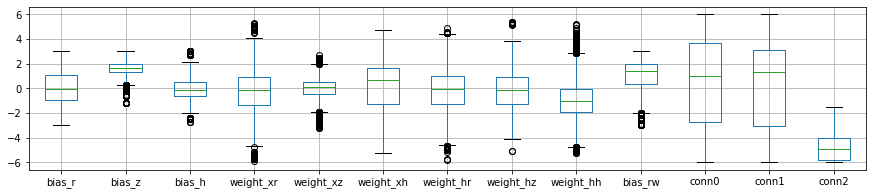

In [10]:
plt.figure(figsize=(15,3))
data_pd.boxplot()
plt.show()
plt.close()

In [11]:
def adapt_and_show(data, indices=None):
    data_temp = data
    if indices is not None: data_temp = data_temp[indices.values]
    print(f"Size: {data_temp.shape}")
    plt.figure(figsize=(15,5))
    for i, h in enumerate(head):
        plt.subplot(int(len(head)/6+1),6,i+1)
        sns.violinplot(data_temp[h])
        plt.title(h)
        if 'bias' in h:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
        plt.yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

Size: (950, 13)


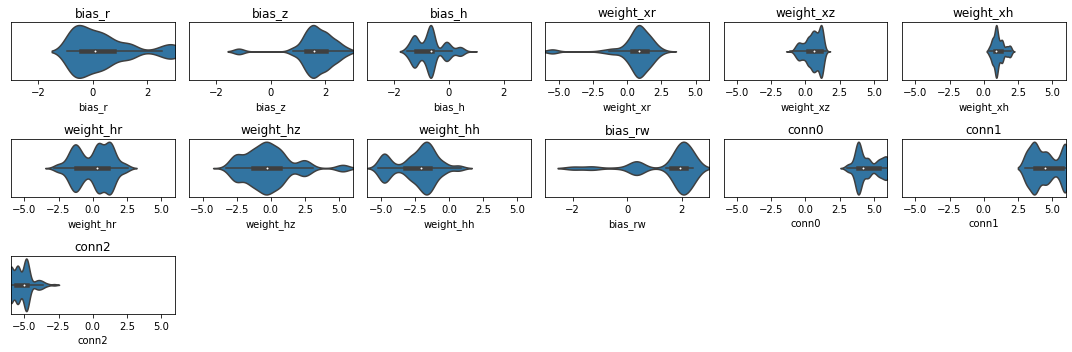

In [19]:
indices = (data_pd['conn1'] >= 3) & (data_pd['conn0'] >= 3)
# indices = None
adapt_and_show(data_pd, indices)

Size: (691, 19)


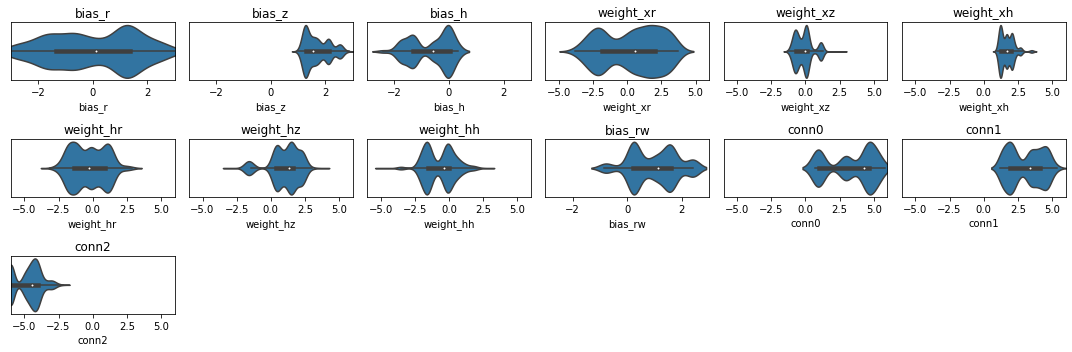

In [46]:
# PP
indices = (data_pd['conn1'] >= 0) & (data_pd['conn0'] >= 0)
adapt_and_show(data_pd, indices)

Size: (608, 19)


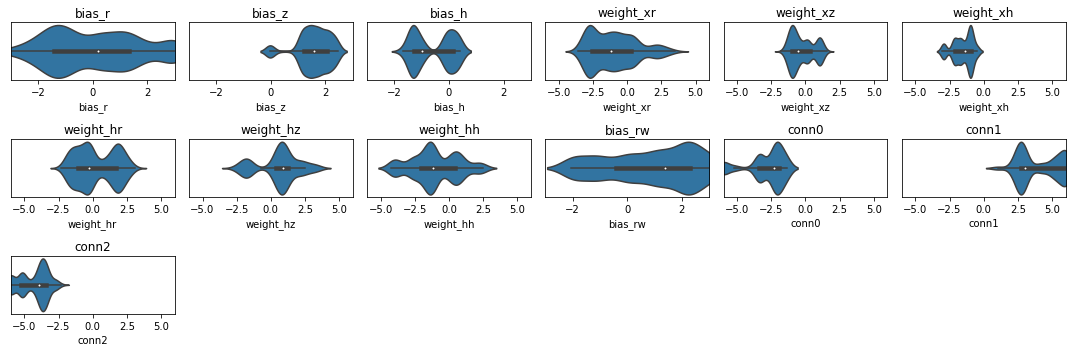

In [47]:
# PN
indices = (data_pd['conn1'] >= 0) & (data_pd['conn0'] < 0)
adapt_and_show(data_pd, indices)

Size: (609, 19)


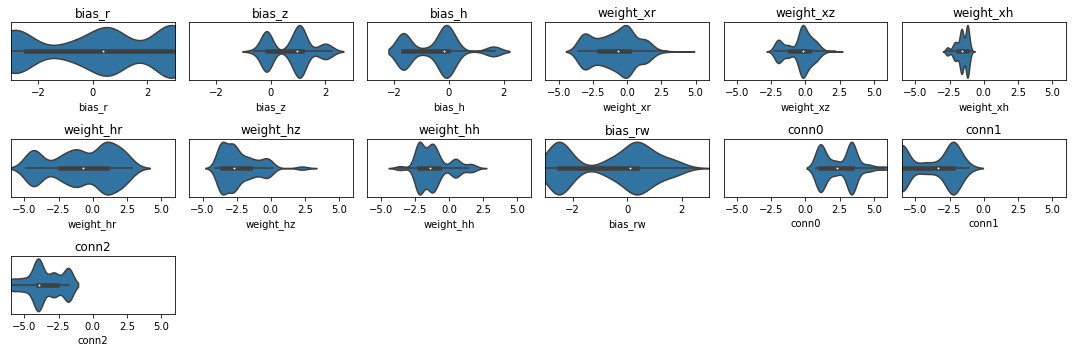

In [48]:
# NP
indices = (data_pd['conn1'] < 0) & (data_pd['conn0'] >= 0)
adapt_and_show(data_pd, indices)

Size: (786, 19)


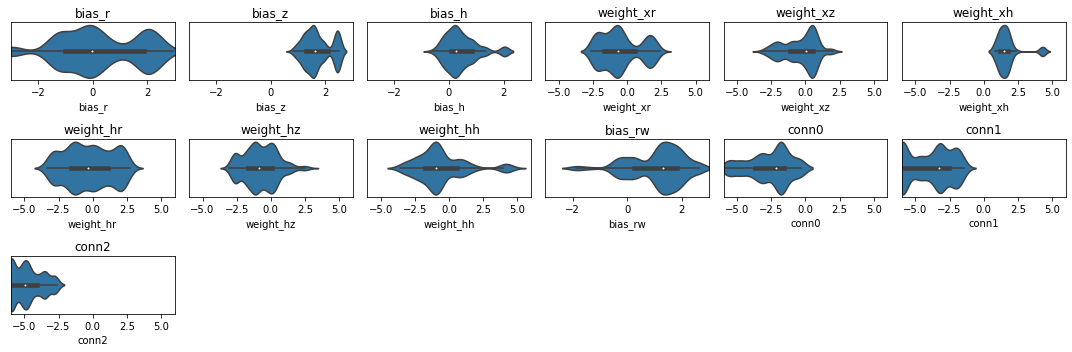

In [49]:
# NN
indices = (data_pd['conn1'] < 0) & (data_pd['conn0'] < 0)
adapt_and_show(data_pd, indices)

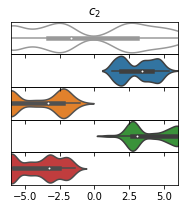

In [41]:
h = 'conn1'
t = '$c_2$'
COLORS = ['#ffffff', sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3]]
plt.figure(figsize=(3,3))
gs1 = gridspec.GridSpec(5,1)
gs1.update(wspace=0, hspace=0)
for i in sorted([i for i in range(5)], reverse=True):
    plt.subplot(gs1[i])
    if i == 0: plt.title(t)
    
    # Format data
    if i == 0:
        data_temp = data_pd
    elif i == 1:
        indices = (data_pd['conn0'] >= 0) & (data_pd['conn1'] >= 0)
        data_temp = data_pd[indices.values]
    elif i == 2:
        indices = (data_pd['conn0'] >= 0) & (data_pd['conn1'] < 0)
        data_temp = data_pd[indices.values]
    elif i == 3:
        indices = (data_pd['conn0'] < 0) & (data_pd['conn1'] >= 0)
        data_temp = data_pd[indices.values]
    else:
        indices = (data_pd['conn0'] < 0) & (data_pd['conn1'] < 0)
        data_temp = data_pd[indices.values]        
        
    # Create the plot
    sns.violinplot(data_temp[h], color=COLORS[i])
    if 'bias' in h:
        plt.xlim(-3,3)
    else:
        plt.xlim(-6,6)
    plt.yticks([])
    plt.xlabel('')
    if i < 4: 
        plt.gca().set_xticklabels([])
plt.savefig(f"delete_me/{h}.png", bbox_inches='tight', pad_inches=0.02)
plt.savefig(f"delete_me/{h}.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

### Add column

Used to color the plots.

In [18]:
def classify_connections(r):
    if r['conn0'] >= 0 and r['conn1'] >= 0:
        return "PP"  # Positive Positive
    elif r['conn0'] >= 0 and r['conn1'] < 0:
        return "PN"  # Positive Negative
    elif r['conn0'] < 0 and r['conn1'] >= 0:
        return "NP"  # Negative Positive
    else:
        return "NN"  # Negative Negative

In [19]:
if classify:
    data_pd['classes'] = data_pd.apply(lambda row: classify_connections(row), axis=1).values
    data_pd.head()

## PCA

In [20]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_pd[head].values)
data_pd['pca-one'] = pca_result[:,0]
data_pd['pca-two'] = pca_result[:,1] 
data_pd['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.3623573  0.2225915  0.10183004]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


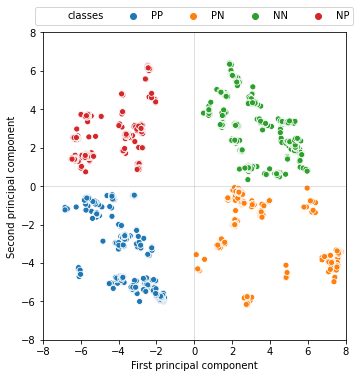

In [27]:
plt.figure(figsize=(5,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="classes",
    palette="tab10",
    data=data_pd,
)
plt.tight_layout()
leg = plt.legend(loc='upper center',
                 bbox_to_anchor=(0.5, 1.1),
                 fancybox=True,
                 fontsize=10,
                 ncol=5)
plt.axhline(0, linewidth=0.5, color=(0.5,0.5,0.5,0.5))
plt.axvline(0, linewidth=0.5, color=(0.5,0.5,0.5,0.5))
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig(f"delete_me/pca.png", bbox_inches='tight', pad_inches=0.02)
plt.savefig(f"delete_me/pca.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

In [22]:
# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# ax.scatter(
#     xs=df["pca-one"], 
#     ys=df["pca-two"], 
#     zs=df["pca-three"], 
# #     xs=df.loc[rndperm,:]["pca-one"], 
# #     ys=df.loc[rndperm,:]["pca-two"], 
# #     zs=df.loc[rndperm,:]["pca-three"], 
# #     cmap='tab10',
# #     c=[int(i) for i in df.loc[rndperm,:]["y"]], 
#     c=[(1, 1-5*(1-min(i,1)), 0, min(i,1)) for i in df["finished"]], 
# )
# ax.set_xlabel('pca-one')
# ax.set_ylabel('pca-two')
# ax.set_zlabel('pca-three')
# plt.show()

## t-SNE

In [23]:
df_values = data_pd[head].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_values)
data_pd['pca-one'] = pca_result[:,0]
data_pd['pca-two'] = pca_result[:,1] 
data_pd['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.3623573  0.2225915  0.10183004]


In [24]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2694 samples in 0.014s...
[t-SNE] Computed neighbors for 2694 samples in 0.228s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2694
[t-SNE] Computed conditional probabilities for sample 2000 / 2694
[t-SNE] Computed conditional probabilities for sample 2694 / 2694
[t-SNE] Mean sigma: 0.466083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.080585
[t-SNE] KL divergence after 300 iterations: 0.541593
t-SNE done! Time elapsed: 8.288896083831787 seconds


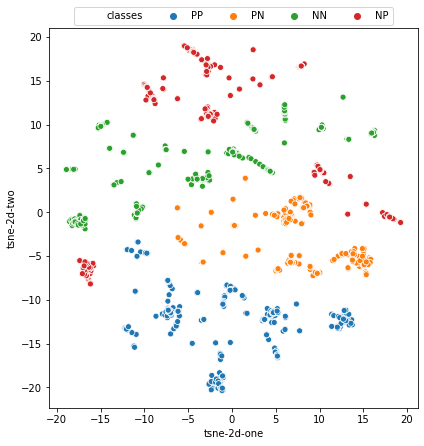

In [25]:
data_pd['tsne-2d-one'] = tsne_results[:,0]
data_pd['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="classes",
    data=data_pd,
)

plt.tight_layout()
leg = plt.legend(loc='upper center',
                 bbox_to_anchor=(0.5, 1.07),
                 fancybox=True,
                 fontsize=10,
                 ncol=5)
plt.show()
plt.close()

In [26]:
# time_start = time.time()
# tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(df_values)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# df['tsne-3d-one'] = tsne_results[:,0]
# df['tsne-3d-two'] = tsne_results[:,1]
# df['tsne-3d-three'] = tsne_results[:,2]
# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# ax.scatter(
#     xs=df["tsne-3d-one"], 
#     ys=df["tsne-3d-two"], 
#     zs=df["tsne-3d-three"], 
# #     xs=df.loc[rndperm,:]["pca-one"], 
# #     ys=df.loc[rndperm,:]["pca-two"], 
# #     zs=df.loc[rndperm,:]["pca-three"], 
# #     cmap='tab10',
# #     c=[int(i) for i in df.loc[rndperm,:]["y"]], 
#     c=[(1, 1-5*(1-min(i,1)), 0, min(i,1)) for i in df["finished"]], 
# )
# ax.set_xlabel('tsne-3d-one')
# ax.set_ylabel('tsne-3d-two')
# ax.set_zlabel('tsne-3d-three')
# plt.show()